In [1]:
# see test file test_discrete_heat_forced.sh
# this file runs the second part of the test, against analytical results for discrete linear problem

In [12]:
import numpy as np
from pandas import DataFrame
import sys
import os
from glob import glob
from json import load as json_load
from numpy.fft import fft,ifft,fftfreq,fftshift
from numpy import sin,cos,exp,log,sqrt,pi

## Matplotlib Parameters

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [4]:
colors = plt.cm.Blues(np.linspace(0,1,10))
colors = plt.cm.viridis(np.linspace(1,0,10))

In [5]:
#rcParams['lines.linewidth'] = 2
#rcParams['lines.linestyle'] = '--'
rcParams['axes.titlesize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'
#rcParams['font.family'] = "sans-serif"
#rcParams['font.family'] = ["Helvetica"]
#rcParams['font.sans-serif'] = ['Helvetica']

In [6]:
from matplotlib.ticker import FuncFormatter

def format_basis10(x):
    return np.sign(x)*10**(-np.floor(np.log10(abs(x)))+np.log10(abs(x)))

def format_exp10(x):
    return np.floor(np.log10(abs(x)))

def MyFormatter(x,lim):
    if x == 0:
        return f'$0$'
    return f'${format_basis10(x):.1f} \\times 10^{{{format_exp10(x):.0f}}}$'
    #The first argument of the format gives the first significant digits of the number with the sign preserved and brought to a range between [1-10), The next argument gives the  numbers integer exponent of 10
    #Both the first and second arguments are formatted to display only 2 decimal places due to the lack of space.
    
majorFormatter = FuncFormatter(MyFormatter)

## Load data

In [62]:
# parent directory
path = os.path.abspath(os.path.join(os.path.abspath(''), os.pardir))
sys.path.append(path+'/scripts')

In [63]:
from _functions import *

In [64]:
# hashes are saved with 10 characters, hence 10 ?
# is there a better way to do this without regex ?
all_files = glob(f'{path}/data/params_??????????.json')
all_files.sort()

In [65]:
all_files

['/Users/bt308146/Github/burgers-spectral-python/data/params_00393bf508.json',
 '/Users/bt308146/Github/burgers-spectral-python/data/params_007ad8ca93.json',
 '/Users/bt308146/Github/burgers-spectral-python/data/params_5c839169f0.json']

In [66]:
for i,file_path in enumerate(all_files):
    with open(file_path,'r') as file:
        if i==0:
            json_data = json_load(file)
            df = DataFrame([json_data])
        else:
            json_data = json_load(file)
            df.loc[i] = json_data

In [67]:
df

,BN,Lrelative,Ttotal,N,nu,Ltotal,L,sqeps,dx,NT,...,sqdx,cfl_const,dt,nlinear,fkernel,initial_value,scheme,saveformat,R,dict_hash
0,8,0.125,10.0,256,0.01,1.0,0.125,1.0,0.003906,655360,...,0.0625,1.0,0.000015,False,zero_smooth_fourier_forcing,zero_initial,ETD,fourier,0,00393bf508
1,4,0.125,10.0,16,0.01,1.0,0.125,1.0,0.062500,25600,...,0.2500,0.1,0.000391,False,zero_smooth_fourier_forcing,zero_initial,ETD,fourier,0,007ad8ca93
2,8,0.125,1.0,256,0.01,1.0,0.125,1.0,0.003906,655360,...,0.0625,0.1,0.000002,True,zero_forcing,sine_initial,ETD,real,0,5c839169f0


In [68]:
# choose the one with nlinear=False, BN>4, fkernel = zero_smooth_fourier_forcing, initial_value = zero_initial
prefix = 0

BN              = df.at[prefix,'BN']
Lrelative       = df.at[prefix,'Lrelative']
Ttotal          = df.at[prefix,'Ttotal']
N               = df.at[prefix,'N']
nu              = df.at[prefix,'nu']
Ltotal          = df.at[prefix,'Ltotal']
L               = df.at[prefix,'L']
sqeps           = df.at[prefix,'sqeps']
dx              = df.at[prefix,'dx']
NT              = df.at[prefix,'NT']
NTsave          = df.at[prefix,'NTsave']
viscte          = df.at[prefix,'viscte']
sqdx            = df.at[prefix,'sqdx']
cfl_const       = df.at[prefix,'cfl_const']
dt              = df.at[prefix,'dt']
nlinear         = df.at[prefix,'nlinear']
fkernel         = df.at[prefix,'fkernel']
initial_value   = df.at[prefix,'initial_value']
scheme          = df.at[prefix,'scheme']
saveformat      = df.at[prefix,'saveformat']
R               = df.at[prefix,'R']
dict_hash       = df.at[prefix,'dict_hash']

In [69]:
dk = 1./Ltotal

# Ensemble specifications

In [70]:
file_suffix = f'R_{R:05d}_{dict_hash}'

In [71]:
# hashes are saved with 10 characters, hence 10 ?
# is there a better way to do this without regex ?
all_files = glob(f'{path}/data/burgers_R_*_{dict_hash}.npz')
all_files.sort()

In [72]:
ens_size = len(all_files)

In [73]:
ens_size

100

# Plot Velocity Field Profiles

In [74]:
vfourier = np.load(path+'/data/burgers_'+file_suffix+'.npz')['u']

In [75]:
vspace = ifft(vfourier,axis=1)

In [76]:
X = fftshift( fftfreq(N) * Ltotal )

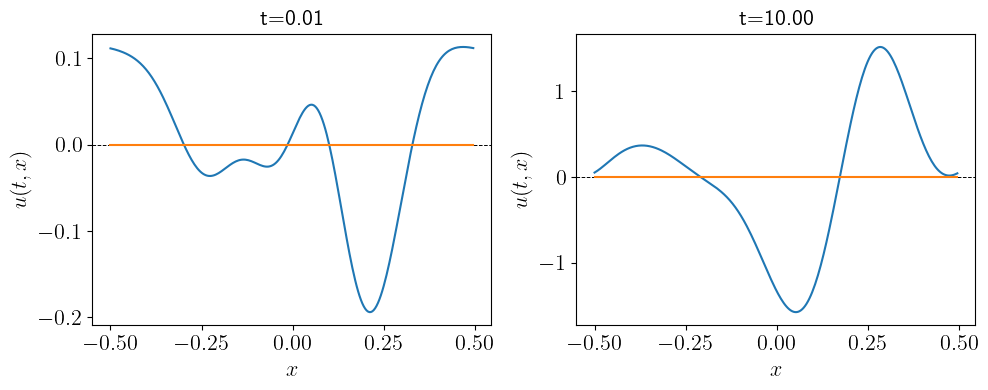

In [77]:
# initial profile of velocity field
fig, ax = plt.subplots(1,2, figsize=(10,4))

t_slice = 0
ax[0].set_title(f"t={(t_slice+1)/NTsave*Ttotal:.2f}")
ax[0].set_ylabel("$u(t,x)$")
ax[0].set_xlabel("$x$")
ax[0].axhline(y=0,linestyle='dashed',color='k',linewidth=0.7) # axis line
ax[0].plot(X,np.real(np.fft.fftshift(vspace[0,:])),label='real part')
ax[0].plot(X,np.imag(np.fft.fftshift(vspace[0,:])),label='real part')

t_slice = NTsave-1
# final profile of velocity field
ax[1].set_title(f"t={(t_slice+1)/NTsave*Ttotal:.2f}")
ax[1].set_ylabel("$u(t,x)$")
ax[1].set_xlabel("$x$")
ax[1].axhline(y=0,linestyle='dashed',color='k',linewidth=0.7) # axis line
ax[1].plot(X,np.real(np.fft.fftshift(vspace[t_slice,:])))
ax[1].plot(X,np.imag(np.fft.fftshift(vspace[t_slice,:])))

plt.tight_layout()
#plt.savefig(f'{path}/figs/bwn_velocity_profile_finite.png', dpi=200, facecolor='white', transparent=False)
plt.show()

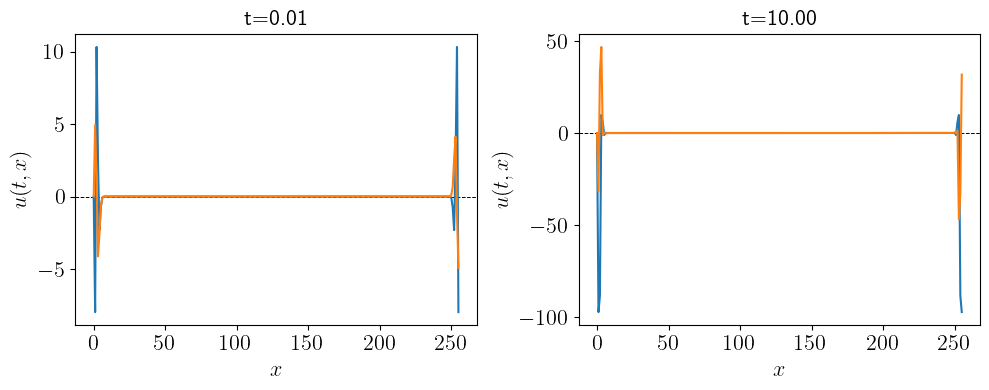

In [78]:
# fourier profile of velocity field, fourier space
fig, ax = plt.subplots(1,2, figsize=(10,4))

t_slice = 0
ax[0].set_title(f"t={(t_slice+1)/NTsave*Ttotal:.2f}")
ax[0].set_ylabel("$u(t,x)$")
ax[0].set_xlabel("$x$")
ax[0].axhline(y=0,linestyle='dashed',color='k',linewidth=0.7) # axis line
ax[0].plot(np.real(fft(vspace[t_slice,:])),label='real part')
ax[0].plot(np.imag(fft(vspace[t_slice,:])),label='imag part')

t_slice = NTsave-1
# final profile of velocity field
ax[1].set_title(f"t={(t_slice+1)/NTsave*Ttotal:.2f}")
ax[1].set_ylabel("$u(t,x)$")
ax[1].set_xlabel("$x$")
ax[1].axhline(y=0,linestyle='dashed',color='k',linewidth=0.7) # axis line
ax[1].plot(np.real(fft(vspace[t_slice,:])),label='real part')
ax[1].plot(np.imag(fft(vspace[t_slice,:])),label='imag part')

plt.tight_layout()
#plt.savefig(f'{path}/figs/bwn_velocity_profile_finite.png', dpi=200, facecolor='white', transparent=False)
plt.show()

# Force statistics

check force variance
Parseval theorem states that variance in Fourier and real space is the same

$$
\sum_n \mathbb{E}|u_n|^2 = \sum_k \mathbb{E}|\widehat{u}_k|^2 = \sum_k \hat{C}_f(k)
$$

In [83]:
f_var_fourier = 0.
f_var_space   = 0.

for R in range(ens_size):
    
    file_name = f'{path}/data/burgers_R_{R:05d}_{dict_hash}.npz'
    
    ffourier = np.load(file_name)['f']
    
    fspace   = ifft(ffourier,axis=1)
    
    f_var_space   += np.mean( np.abs(fspace)**2 )
    f_var_fourier += np.mean( np.abs(ffourier)**2 ) / N
    
f_var_space   *= 1./ens_size
f_var_fourier *= 1./ens_size

In [86]:
print(f'parseval absolute diff (real, fourier) = {np.abs(f_var_space - f_var_fourier)}')
print(f'parseval absolute diff (real, analyt)  = {np.abs(f_var_space - 1.0)}')

parseval absolute diff (real, fourier) = 0.0
parseval absolute diff (real, analyt)  = 0.00034125333883960884


In [87]:
f_all = np.array([])

for i in range(ens_size):
    
    file_name = f'{path}/data/burgers_R_{R:05d}_{dict_hash}.npz'
    
    fspace = ifft( np.load(file_name)['f'] , axis=1).flatten()
    
    f_all = np.concatenate(( f_all, fspace ))

In [88]:
hist, bin_edges = np.histogram( np.real(f_all), bins=300, density=True )

bin_centers = .5*bin_edges[1:] + .5*bin_edges[:-1]

In [89]:
def f_pdf(f,sigma2):
    
    cte = 1./sqrt(2.*pi*sigma2)
    
    return cte*exp(-.5*f**2/sigma2)

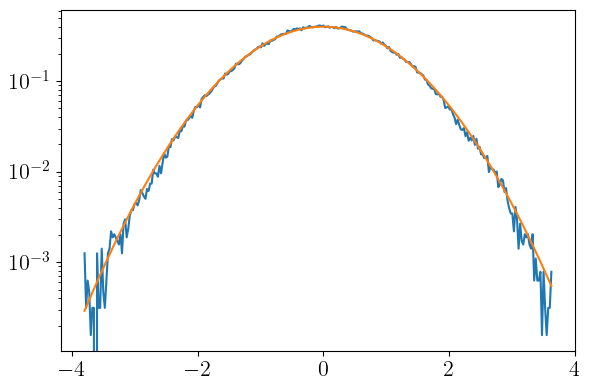

In [90]:
fig,ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(bin_centers, hist)

ax.plot(bin_centers, f_pdf(bin_centers,1.0))

ax.set_yscale('log')

plt.tight_layout()
plt.show()

## Velocity Variance in Time

In [99]:
v_var_time = np.zeros(NTsave)

for R in range(ens_size):
    
    file_name = f'{path}/data/burgers_R_{R:05d}_{dict_hash}.npz'
    
    vfourier    = np.load(file_name)['u']
    
    vspace      = ifft(vfourier,axis=1)
    
    v_var_time += np.mean( np.abs(vspace)**2, axis=1 )
    
v_var_time *= 1./ens_size

In [100]:
t_axis = np.arange(1,NTsave+1)/NTsave*Ttotal

In [122]:
v_var_time_analytical = .5*L**2/nu

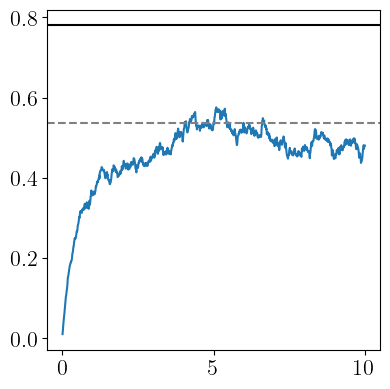

In [125]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(t_axis, v_var_time)
ax.axhline(y=v_var_time_analytical, color='k')
ax.axhline(y=0.536462, color='gray', linestyle='dashed' )

plt.tight_layout()
plt.show()

In [106]:
v_all = np.array([])

for R in range(ens_size):
    
    file_name = f'{path}/data/burgers_R_{R:05d}_{dict_hash}.npz'
    
    vspace = ifft( np.load(file_name)['u'] , axis=1)[NTsave//2:,:].flatten()
    
    v_all = np.concatenate(( v_all, vspace ))

In [107]:
hist, bin_edges = np.histogram( np.real(v_all), bins=300, density=True )

bin_centers = .5*bin_edges[1:] + .5*bin_edges[:-1]

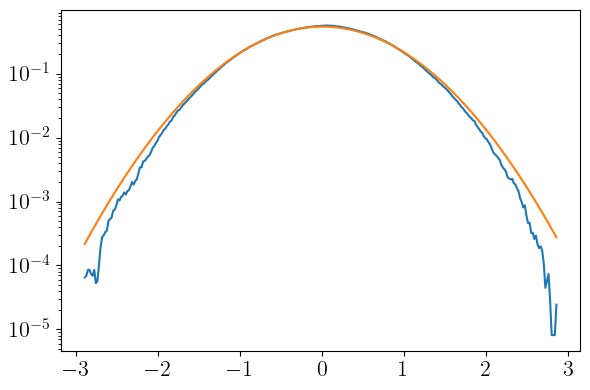

In [109]:
fig,ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(bin_centers, hist)

ax.plot(bin_centers, f_pdf(bin_centers,0.536462))

ax.set_yscale('log')

plt.tight_layout()
plt.show()

## Velocity Gradient Fourier Variance in Time

In [111]:
vg_var_time = np.empty(NTsave)

for R in range(ens_size):
    
    file_name = f'{path}/data/burgers_R_{R:05d}_{dict_hash}.npz'
    
    vgfourier    = np.load(file_name)['dudx']
    
    vgspace      = ifft(vgfourier, axis=1)
    
    vg_var_time += np.mean( np.abs(vgspace)**2, axis=1 )
    
vg_var_time *= 1./ens_size

In [112]:
vg_var_time_analytical = .5/nu

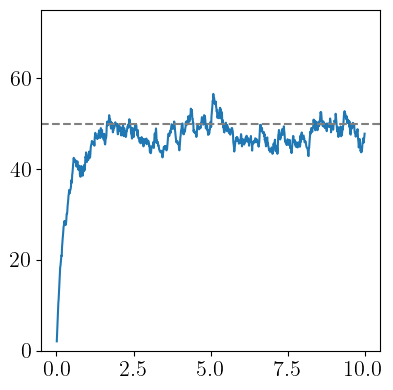

In [119]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(t_axis, vg_var_time)
ax.axhline(y=vg_var_time_analytical, color='gray', linestyle='dashed')
ax.set_ylim(0.,1.5*vg_var_time_analytical)

plt.tight_layout()
plt.show()

In [50]:
vg_all = np.array([])

for R in range(ens_size):
    
    file_name = f'{path}/data/burgers_R_{R:05d}_{dict_hash}.npz'
        
    vgspace = ifft( np.load(file_name)['dudx'] , axis=1)[NTsave//2:,:].flatten()
    
    vg_all = np.concatenate(( vg_all, vgspace ))

In [51]:
hist, bin_edges = np.histogram( np.real(vg_all), bins=300, density=True )

bin_centers = .5*bin_edges[1:] + .5*bin_edges[:-1]

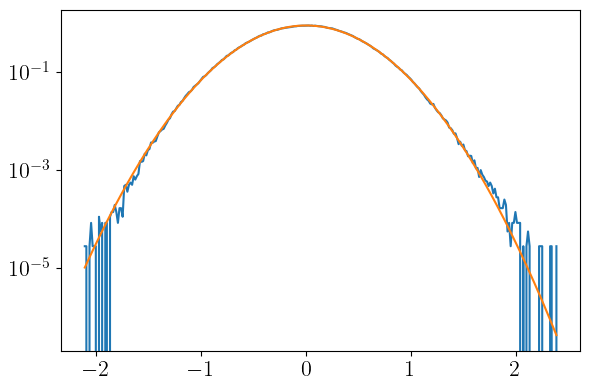

In [53]:
fig,ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(bin_centers, hist)

ax.plot(bin_centers, f_pdf(bin_centers,50.*dx*dx))

ax.set_yscale('log')

plt.tight_layout()
plt.show()